# Assignment-2: CNNs and RNNs

# Name: Shrenik Ganguli
# Roll No: CS23MTECH14014

## CNNs

In [1]:
# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import random
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear as layer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use('seaborn')

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def normalize_image(image):
    # Convert to floating-point
    image = image.astype(np.float32)
    # Scale pixel values to [0, 1]
    image /= 255.0
    return image

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

### Q1 - Convolution function

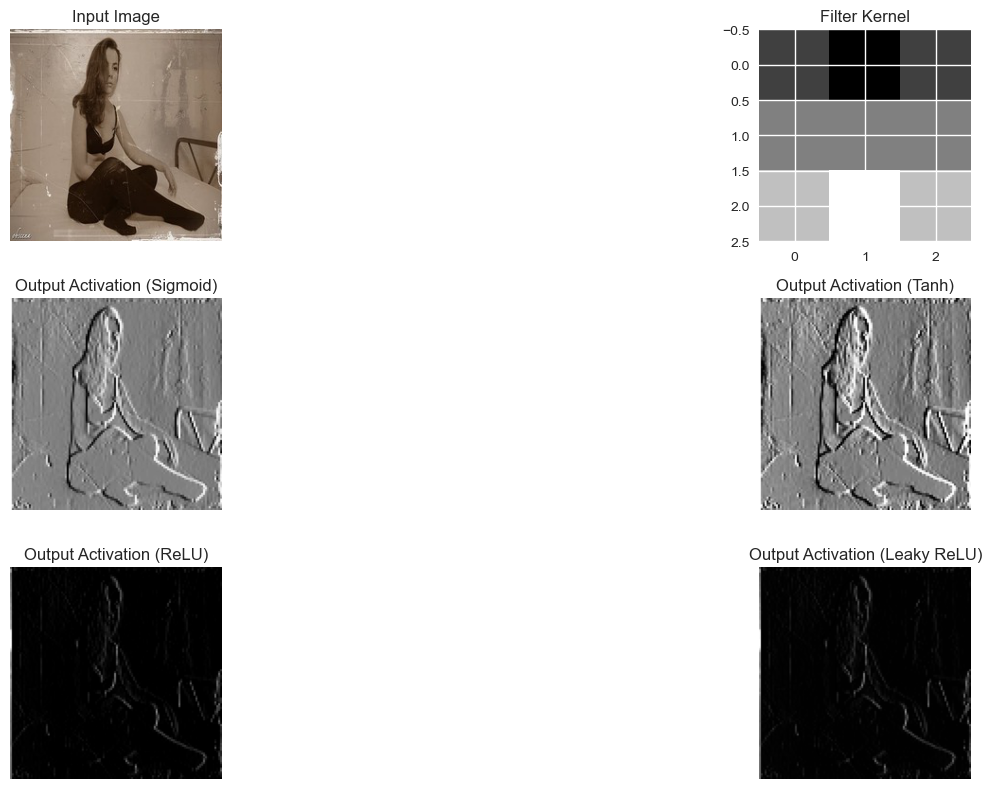

In [3]:
def convolution(input_image, kernel, stride, padding, activation_function):
    
    input_height, input_width, input_channels = input_image.shape
    kernel_height, kernel_width, kernel_channels = kernel.shape
    

    output_height = ((input_height + 2 * padding - kernel_height) // stride) + 1
    output_width  = ((input_width + 2 * padding - kernel_width) // stride) + 1
    

    padded_input = np.pad(input_image, ((padding, padding), (padding, padding), (0, 0)), mode='constant') if padding > 0 else input_image
    
    output_activation = np.zeros((output_height, output_width))

    for i in range(0, output_height):
        
        for j in range(0, output_width):

            receptive_field = padded_input[i * stride:i * stride + kernel_height, j * stride:j * stride + kernel_width, :]

            output_activation[i, j] = np.sum(np.multiply(receptive_field, kernel), axis=(0, 1, 2))
            
    return activation_function(output_activation)


# Example usage
file_path = 'girl.jpeg'
input_image = imageio.imread(file_path)
normalized_input_image = normalize_image(input_image)

# Vertical Edge detection kernel
kernel = np.array(
    [
        [
            [-1, -2, -1],
            [0, 0, 0],
            [1, 2, 1]
        ],
        [
            [-1, -2, -1],
            [0, 0, 0],
            [1, 2, 1]
        ],
        [
            [-1, -2, -1],
            [0, 0, 0],
            [1, 2, 1]
        ]
    ]
)

stride = 2
padding = 1

# Choose parameters
activation_functions = [sigmoid, tanh, relu, lambda x: leaky_relu(x, alpha=0.01)]
activation_names = ['Sigmoid', 'Tanh', 'ReLU', 'Leaky ReLU']

plt.figure(figsize=(20, 8))

plt.subplot(3, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks

plt.subplot(3, 2, 2)
plt.imshow(kernel.sum(axis=0), cmap='gray')
plt.title('Filter Kernel')

i=3
output_activation_list=[]


for activation_function, activation_name in zip(activation_functions, activation_names):
    
    output_activation = convolution(normalized_input_image, kernel, stride, padding, activation_function)
    output_activation_list.append(output_activation)
    #plot_convolution(output_activation, activation_name,i)
    plt.subplot(3, 2, i)
    plt.imshow(output_activation, cmap='gray')
    plt.title(f'Output Activation ({activation_name})')
    plt.grid(False)  # This line disables the grid
    plt.axis('off')  # This line turns off the axis labels and ticks
    i+=1

plt.tight_layout()
plt.show()

### Q2 - Pooling function

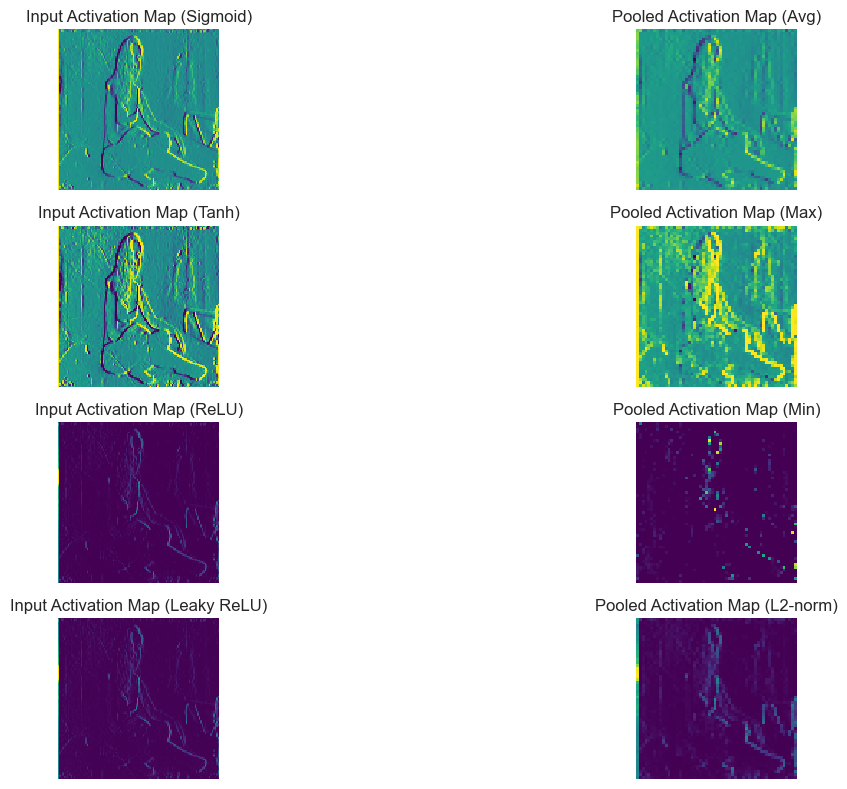

In [4]:
def pooling(activation_map, pool_type, pool_size, stride):

    height, width = activation_map.shape

    pooled_height = (height - pool_size) // stride + 1
    pooled_width = (width - pool_size) // stride + 1

    pooled_activation_map = np.empty((pooled_height, pooled_width))

    #pooled_activation_map = np.zeros((pooled_height, pooled_width))

    for h in range(pooled_height):
        for w in range(pooled_width):
            pooled_activation_map[h][w] = 0

    for i in range(0, pooled_height * stride, stride):
        for j in range(0, pooled_width * stride, stride):
            
            patch = activation_map[i:i+pool_size, j:j+pool_size]

            # Max Pooling
            if pool_type == 'max':
                pooled_activation_map[i//stride, j//stride] = np.max(patch)


            elif pool_type == 'avg':
                pooled_activation_map[i//stride, j//stride] = np.mean(patch)


            elif pool_type == 'min':
                pooled_activation_map[i//stride, j//stride] = np.min(patch)


            elif pool_type == 'l2':
                pooled_activation_map[i//stride, j//stride] = np.linalg.norm(patch)
                
            else:
                raise ValueError('Invalid Pooling Function')

    return pooled_activation_map


plt.figure(figsize=(16, 8))

# Display the input activation map
plt.subplot(4, 2, 1)
plt.imshow(output_activation_list[0], cmap='viridis', interpolation='nearest')
plt.title('Input Activation Map (Sigmoid)')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks
# Apply max pooling with pool size 2x2 and stride 2
pooled_activation_map_sigmoid = pooling(output_activation_list[0], pool_type='avg', pool_size=2, stride=2)
# Display the pooled output
plt.subplot(4, 2, 2)
plt.imshow(pooled_activation_map_sigmoid, cmap='viridis', interpolation='nearest')
plt.title('Pooled Activation Map (Avg)')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks


plt.subplot(4, 2, 3)
plt.imshow(output_activation_list[1], cmap='viridis', interpolation='nearest')
plt.title('Input Activation Map (Tanh)')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks
# Apply max pooling with pool size 2x2 and stride 2
pooled_activation_map_tanh = pooling(output_activation_list[1], pool_type='max', pool_size=2, stride=2)
# Display the pooled output
plt.subplot(4, 2, 4)
plt.imshow(pooled_activation_map_tanh, cmap='viridis', interpolation='nearest')
plt.title('Pooled Activation Map (Max)')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks


plt.subplot(4, 2, 5)
plt.imshow(output_activation_list[2], cmap='viridis', interpolation='nearest')
plt.title('Input Activation Map (ReLU)')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks
# Apply max pooling with pool size 2x2 and stride 2
pooled_activation_map_relu = pooling(output_activation_list[2], pool_type='min', pool_size=2, stride=2)
# Display the pooled output
plt.subplot(4, 2, 6)
plt.imshow(pooled_activation_map_relu, cmap='viridis', interpolation='nearest')
plt.title('Pooled Activation Map (Min)')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks


plt.subplot(4, 2, 7)
plt.imshow(output_activation_list[3], cmap='viridis', interpolation='nearest')
plt.title('Input Activation Map (Leaky ReLU)')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks
# Apply max pooling with pool size 2x2 and stride 2
pooled_activation_map_leaky_relu = pooling(output_activation_list[3], pool_type='l2', pool_size=2, stride=2)
# Display the pooled output
plt.subplot(4, 2, 8)
plt.imshow(pooled_activation_map_leaky_relu, cmap='viridis', interpolation='nearest')
plt.title('Pooled Activation Map (L2-norm)')
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks


plt.tight_layout()
plt.show()

### Q3 - Convolution layer function

In [5]:
pooled_stack = np.stack([
    pooled_activation_map_sigmoid,
    pooled_activation_map_tanh,
    pooled_activation_map_relu,
    pooled_activation_map_leaky_relu
], axis=-1)

In [6]:
def convolution_layer(input_volume, num_filters, kernel_size, stride, padding, activation_function):

    list_output_activation = []
    filters_list = []

    input_height, input_width, input_channels = input_volume.shape

    for i in range(num_filters):

        filter = np.random.randn(kernel_size[0], kernel_size[1], input_channels)
        filters_list.append(filter)

        output_activation = convolution(input_volume,filter,stride,padding,activation_function)

        list_output_activation.append(output_activation)

    return(list_output_activation, filters_list)


list_output_activation, filters_list = convolution_layer(pooled_stack, 3, (pooled_stack.shape[2],pooled_stack.shape[2]), 1, 0, relu)
output_activation_array = np.array(list_output_activation)

In [7]:
output_activation_array = np.transpose(output_activation_array, (1,2,0))

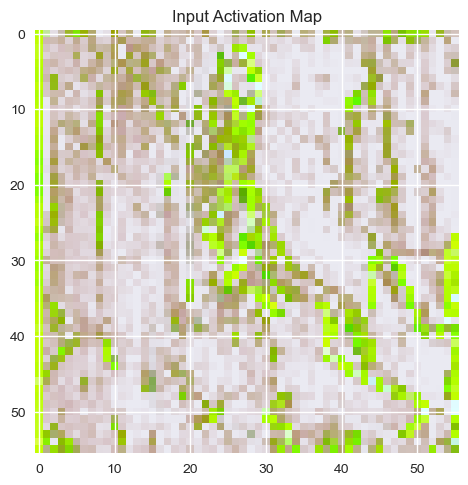

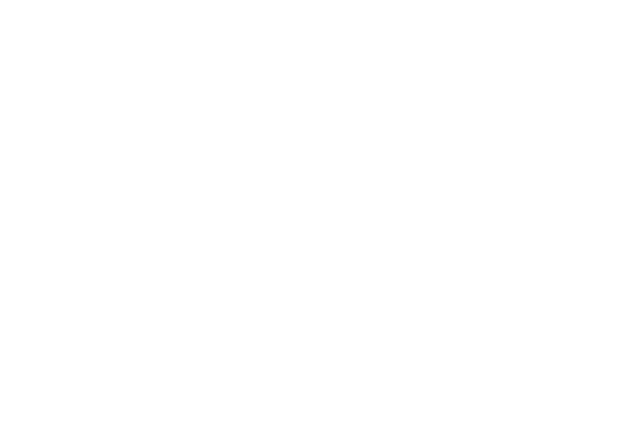

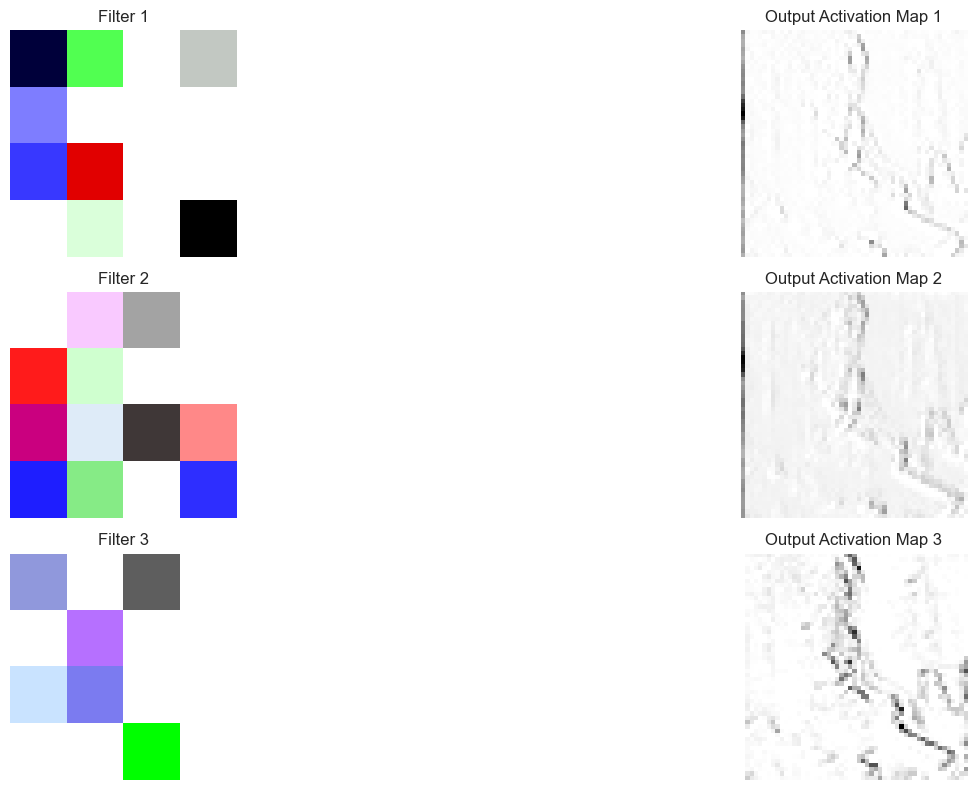

In [8]:
plt.imshow(np.clip(pooled_stack,0,1), cmap='gray')
plt.title('Input Activation Map')
plt.show()
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks

plt.figure(figsize=(20, 8))
k=1
for i in range(1, len(filters_list)+1):
    plt.subplot(len(filters_list),2,k)
    plt.imshow(np.clip(filters_list[i-1],0,1))
    plt.title(f'Filter {i}')
    plt.grid(False)  # This line disables the grid
    plt.axis('off')  # This line turns off the axis labels and ticks

    k+=1

    plt.subplot(len(filters_list),2,k)
    plt.imshow(list_output_activation[i-1])
    plt.title(f'Output Activation Map {i}')
    plt.grid(False)  # This line disables the grid
    plt.axis('off')  # This line turns off the axis labels and ticks

    k+=1

plt.tight_layout()
plt.show()

In [9]:
print("Input Dimensions  : ",pooled_stack.shape)
print("Kernel dimensions :", filters_list[0].shape)
print("Number of kernels : ", len(filters_list))
print("Output Dimensions :", output_activation_array.shape)

Input Dimensions  :  (56, 56, 4)
Kernel dimensions : (4, 4, 4)
Number of kernels :  3
Output Dimensions : (53, 53, 3)


The input dimensions are 50 x 50 x 4 (W x H x C)

The kernel dimensions are 4 x 4 x 4 (w x h x C)

Therefore output dimensions are: 47 x 47 x 3 (W-w+1  x  H-h+1  x  D) [since padding=0, stride=1]

Where,

W,H,C is width, height and no. of channels in input image respectively  

w,h,c is width, height and no. of channels in input image respectively

D is no. of kernels used

### Q4 - Pooling layer function

In [10]:
def pooling_layer(activation_map, pool_type, pool_size, stride):

    if pool_type == 'global_avg':
        # Global Average Pooling for 3D input
        pooled_activation_map = np.mean(activation_map, axis=(0, 1))

        return pooled_activation_map

    else:
        pooled_activation_maps_list = []

        for c in range(activation_map.shape[2]):
            pooled_activation_map = pooling(activation_map[:,:,c], pool_type, pool_size, stride)
            pooled_activation_maps_list.append(pooled_activation_map)
            
        stacked_pooled_activation_maps = np.stack(pooled_activation_maps_list, axis=2)

        return stacked_pooled_activation_maps


pooled_activation_map_gap = pooling_layer(output_activation_array, pool_type='global_avg', pool_size=2, stride=2)
pooled_activation_map_max = pooling_layer(output_activation_array, pool_type='max', pool_size=2, stride=2)
pooled_activation_map_min = pooling_layer(output_activation_array, pool_type='min', pool_size=2, stride=2)
pooled_activation_map_avg = pooling_layer(output_activation_array, pool_type='avg', pool_size=2, stride=2)
pooled_activation_map_l2 = pooling_layer(output_activation_array, pool_type='l2', pool_size=2, stride=2)

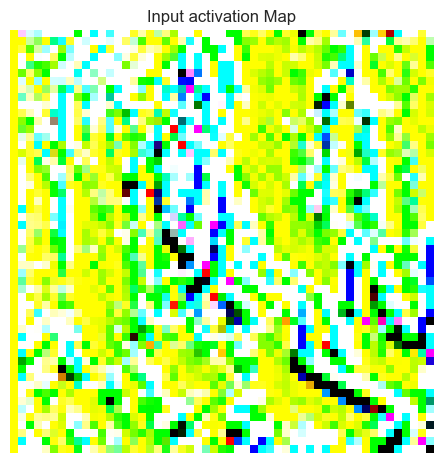

In [11]:
if output_activation_array.shape[2] == 3:
    plt.imshow(np.clip(output_activation_array, 0, 1), cmap='gray')
    plt.title('Input activation Map')
    plt.grid(False)  # This line disables the grid
    plt.axis('off')  # This line turns off the axis labels and ticks

In [12]:
print("Global Average Pooling Output: ", pooled_activation_map_gap)
#print("Max Pooling Output: ", pooled_activation_map_max)
#print("Min Pooling Output: ", pooled_activation_map_min)
#print("Avg Pooling Output: ", pooled_activation_map_avg)
#print("L2-norm  Pooling Output: ", pooled_activation_map_l2)

Global Average Pooling Output:  [2.43551397 3.85881114 1.54213598]


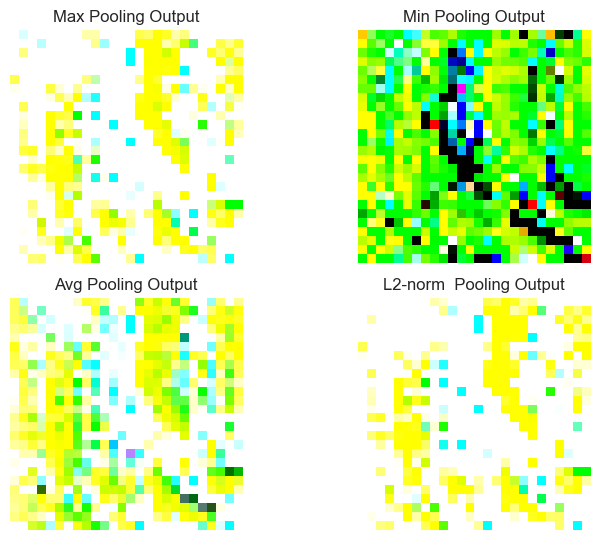

In [13]:
if output_activation_array.shape[2] == 3:
    plt.subplot(2,2,1)
    plt.imshow(np.clip(pooled_activation_map_max,0,1))
    plt.title('Max Pooling Output')
    plt.grid(False)  # This line disables the grid
    plt.axis('off')  # This line turns off the axis labels and ticks


    plt.subplot(2,2,2)
    plt.imshow(np.clip(pooled_activation_map_min,0,1))
    plt.title('Min Pooling Output')
    plt.grid(False)  # This line disables the grid
    plt.axis('off')  # This line turns off the axis labels and ticks


    plt.subplot(2,2,3)
    plt.imshow(np.clip(pooled_activation_map_avg,0,1))
    plt.title('Avg Pooling Output')
    plt.grid(False)  # This line disables the grid
    plt.axis('off')  # This line turns off the axis labels and ticks


    plt.subplot(2,2,4)
    plt.imshow(np.clip(pooled_activation_map_l2,0,1))
    plt.title('L2-norm  Pooling Output')
    plt.grid(False)  # This line disables the grid
    plt.axis('off')  # This line turns off the axis labels and ticks


    plt.tight_layout()
    plt.show()

else:
    print("Max Pooling Output Shape: ", pooled_activation_map_max.shape)
    print("Min Pooling Output Shape: ", pooled_activation_map_min.shape)
    print("Avg Pooling Output Shape: ", pooled_activation_map_avg.shape)
    print("L2-norm  Pooling Output Shape: ", pooled_activation_map_l2.shape)

### Q5 - Multilayer Perceptron (MLP) function

In [14]:
def mlp(input_vector, layer_sizes, activation_function, output_size, apply_softmax):

    input_size = len(input_vector)
    num_hidden_layers = len(layer_sizes)
    weights = []
    biases = []

    # Initialize weights and biases for hidden layers
    for i in range(num_hidden_layers):
        if i == 0:
            weights.append(np.random.randn(input_size, layer_sizes[i]))
        else:
            weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]))
        biases.append(np.zeros(layer_sizes[i]))

    # Initialize weights and biases for output layer
    weights.append(np.random.randn(layer_sizes[-1], output_size))
    biases.append(np.zeros(output_size))

    # Forward pass through hidden layers
    output = input_vector

    for i in range(num_hidden_layers):
        output = activation_function(np.dot(output, weights[i]) + biases[i])

    # Forward pass through output layer
    output = np.dot(output, weights[-1]) + biases[-1]

    # Apply softmax if specified
    if apply_softmax:
        output = softmax(output)

    return output

# Example usage:
input_vector = pooled_activation_map_gap
layer_sizes = [5, 3, 4]  # Example hidden layer sizes
output_size = 3

# Using sigmoid activation function and applying softmax to the output layer
result_with_softmax = mlp(input_vector, layer_sizes, sigmoid, output_size, apply_softmax=True)

# Using relu activation function and not applying softmax to the output layer
result_without_softmax = mlp(input_vector, layer_sizes, relu, output_size, apply_softmax=False)

print("Result with softmax:", result_with_softmax)
print("Result without softmax:", result_without_softmax)

Result with softmax: [0.52561999 0.07440325 0.39997676]
Result without softmax: [0.17647851 0.26268871 0.05066191]


### Q6 - Putting-it all together

Input Image


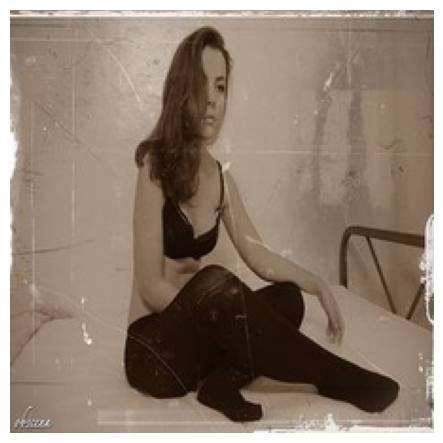

Shape of image (224, 224, 3) 

Shapes after performing convolution with 16 kernels of size 5 × 5 spatial dimensions and ReLU activation:
Input Dimensions:  (224, 224, 3)
Kernel dimensions:  (5, 5, 3)
Number of kernels:  16
Output Dimensions:  (220, 220, 16) 

Shape after passing through max pooling layer of size 2 × 2 with a stride of 2 along each dimension:  (110, 110, 16) 

Shapes after performing convolution with 32 kernels of spatial size 3 × 3 and sigmoid activation: 
Input Dimensions:  (110, 110, 16)
Kernel dimensions:  (3, 3, 16)
Number of kernels:  32
Output Dimensions:  (108, 108, 32) 

Shape after passing through Max pooling layer of size 2 × 2 with a stride of 2 along each dimension:  (54, 54, 32) 

Shape of output of Global Average Pooling (GAP) layer:  (32,)
Output of Global Average Pooling (GAP) layer:  [1.07991871e-04 9.99874832e-01 9.93512404e-01 9.99979465e-01
 9.20478319e-01 5.03808134e-01 9.83002782e-01 9.54017758e-01
 9.06332422e-01 9.97351457e-01 9.99994042e-01 9.9

In [15]:
file_path = 'girl.jpeg'
test_img = imageio.imread(file_path)
print("Input Image")
plt.imshow(test_img)
plt.grid(False)  # This line disables the grid
plt.axis('off')  # This line turns off the axis labels and ticks
plt.show()
print("Shape of image", test_img.shape, "\n")


test_normalized_input_image = normalize_image(test_img)
conv_1, f = convolution_layer(test_normalized_input_image, 16, (5,5), 1, 0, relu)
conv_1 = np.array(conv_1)
conv_1 = np.transpose(conv_1, (1,2,0))
print("Shapes after performing convolution with 16 kernels of size 5 × 5 spatial dimensions and ReLU activation:")
print("Input Dimensions: ", test_normalized_input_image.shape)
print("Kernel dimensions: ", f[0].shape)
print("Number of kernels: ", len(f))
print("Output Dimensions: ", conv_1.shape, "\n")


pool_1 = pooling_layer(conv_1,pool_type='max', pool_size=2, stride=2)
print("Shape after passing through max pooling layer of size 2 × 2 with a stride of 2 along each dimension: ", pool_1.shape, "\n")


conv_2, f_2 = convolution_layer(pool_1, 32, (3,3), 1, 0, sigmoid)
conv_2 = np.array(conv_2)
conv_2 = np.transpose(conv_2, (1,2,0))
print("Shapes after performing convolution with 32 kernels of spatial size 3 × 3 and sigmoid activation: ")
print("Input Dimensions: ", pool_1.shape)
print("Kernel dimensions: ", f_2[0].shape)
print("Number of kernels: ", len(f_2))
print("Output Dimensions: ", conv_2.shape, "\n")


pool_2 = pooling_layer(conv_2,pool_type='max', pool_size=2, stride=2)
print("Shape after passing through Max pooling layer of size 2 × 2 with a stride of 2 along each dimension: ", pool_2.shape,"\n")


gap = pooling_layer(pool_2, pool_type='global_avg', pool_size=2, stride=2)
print("Shape of output of Global Average Pooling (GAP) layer: ",gap.shape)
print("Output of Global Average Pooling (GAP) layer: ",gap, "\n")


mlp_output = mlp(gap, [len(gap)], relu, 1000, apply_softmax=True)
print("Shapes after passingh through an An MLP with one hidden layer (size same as input) and mapping it to 1000 output nodes. Using ReLU activation for the MLP (softmax in the o/p layer).")
print("Shape of input to MLP Layer: ",gap.shape)
print("Shape of output after passing through MLP: ", mlp_output.shape)

In [16]:
print("Final output after passing through MLP: ",mlp_output)

Final output after passing through MLP:  [1.31599179e-35 3.60930757e-29 1.11308474e-16 1.32018425e-16
 1.00586704e-09 2.53074413e-20 4.57236078e-15 2.95562602e-21
 5.28170470e-33 5.24822694e-27 6.58519971e-23 1.98023905e-22
 2.92174283e-21 5.97808964e-21 8.44190299e-16 2.62069055e-23
 1.09955178e-13 1.76182401e-34 2.39092804e-09 2.17116522e-26
 2.23198417e-16 1.28425543e-31 3.38736002e-15 1.38369587e-25
 9.09217188e-20 3.21999652e-14 2.89822258e-13 1.43446459e-19
 4.59872213e-14 3.02826915e-21 1.85248702e-26 3.38530453e-14
 4.72953158e-24 8.35611450e-17 6.70278956e-32 1.35908976e-23
 2.15035433e-19 4.22444905e-23 7.11405645e-13 2.08857054e-16
 1.89116516e-16 7.80639647e-07 1.21919819e-15 1.13905928e-13
 1.56512494e-17 8.88261454e-20 1.26889712e-22 2.60340269e-26
 2.74104935e-27 9.69228746e-07 4.32908635e-25 7.72892847e-22
 1.23931293e-16 2.63365270e-25 1.38039863e-24 4.80950065e-21
 2.01035842e-11 1.55871630e-22 5.14623004e-16 2.08399856e-24
 3.94131623e-19 3.65077545e-17 9.08341270e-1

## RNNs

### Q7 - The adding problem

Dataset Creation

In [17]:
torch.manual_seed(42)

def generate_random_tensor(length):

    random_values = torch.rand((length, 1))

    # Create a tensor with zeros and two elements marked by 1
    output_tensor = torch.zeros((length, 1))
    indices = torch.randint(length, size=(2,))
    output_tensor[indices] = 1

    return torch.cat((random_values, output_tensor), dim=1)

# Generate 5000 tensors with a fixed length of 10
num_tensors = 5000

x_list = []

for i in range(num_tensors):
    length = np.random.randint(3, 10)
    x_list.append(generate_random_tensor(length).double())

y_list = []

for tensor in x_list:
    # Select values from tensor where the second dimension is 1 and compute their sum
    sum_values = tensor[tensor[:, 1] == 1, 0].sum().view(1).double()
    y_list.append(sum_values)

print("Sample Dataset Point:")
print("X: ",x_list[2])
print("Y: ",y_list[2])

Sample Dataset Point:
X:  tensor([[0.2696, 0.0000],
        [0.4414, 0.0000],
        [0.2969, 1.0000]], dtype=torch.float64)
Y:  tensor([0.2969], dtype=torch.float64)


Split Data into training and testing sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.2, random_state=42)

Initialising hyperparameters for all three RNNs

In [19]:
torch.manual_seed(42)
iterations               = 30
input_layer_size         = 2
hidden_layer_size        = 8
output_layer_size        = 1
learning_rate            = 0.001

In [20]:
# Putting training and testing data together
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

Elmon RNN

In [21]:
# Defining the Elmon Model

class ElmonRNN(nn.Module):

    def __init__(self, i_s, h_s, o_s):

        super().__init__()

        self.Wxh  = layer(i_s, h_s, bias=False)
        self.Whh  = layer(h_s, h_s, bias=True)
        self.Why  = layer(h_s, o_s, bias=True)

        self.double()

    def forward(self, xt, ht_1):

        ht  = torch.tanh(self.Wxh(xt) + self.Whh(ht_1))

        yt = self.Why(ht)

        return yt, ht


Elmon_Model = ElmonRNN(input_layer_size, hidden_layer_size, output_layer_size)
print(Elmon_Model)

ElmonRNN(
  (Wxh): Linear(in_features=2, out_features=8, bias=False)
  (Whh): Linear(in_features=8, out_features=8, bias=True)
  (Why): Linear(in_features=8, out_features=1, bias=True)
)


In [22]:
# Training the created Elmon Model
Elmon_Model.train()

# Create a defaultdict to store losses
elmon_loss_dict = defaultdict(int)

# Initialize Smooth L1 loss
elmon_loss = nn.MSELoss()

# Adadelta optimizer
opt = torch.optim.Adam(Elmon_Model.parameters(), lr=learning_rate)

# Training loop
for i in range(iterations):
    iter_loss = 0

    for _,train in enumerate(train_data):

        X_true = train[0]
        Y_true = train[1]

        Elmon_Model.zero_grad()

        ht_prev = torch.zeros(1, hidden_layer_size, requires_grad=False, dtype=torch.float64)

        y_pred = 0

        # Forward pass through the Elmon_Model
        for time_step in range(X_true.shape[0]):

            y_pred, ht_prev = Elmon_Model(X_true[time_step, :], ht_prev)


        # Calculate Huber loss

        current_loss = elmon_loss(y_pred, Y_true)

        current_loss.backward()

        nn.utils.clip_grad_norm_(Elmon_Model.parameters(), 3)

        opt.step()

        # Accumulate loss for the epoch
        iter_loss += current_loss.item()

    # Calculate average loss for the epoch
    elmon_loss_dict[i] = iter_loss / len(train_data)

    if i!=0:
        loss_change_percentage = ((elmon_loss_dict[i-1]-elmon_loss_dict[i])/elmon_loss_dict[i-1]) * 100
        print(f'Epoch {i + 1}: \t Loss = {elmon_loss_dict[i]}\t Loss Change Percentage = {loss_change_percentage}%')
        print("-"*115)

    else:
        print(f'Epoch {i + 1}: \t Loss = {elmon_loss_dict[i]}\t')
        print("-"*115)

Epoch 1: 	 Loss = 0.1441137739987939	
-------------------------------------------------------------------------------------------------------------------
Epoch 2: 	 Loss = 0.04297505898686332	 Loss Change Percentage = 70.17976991760484%
-------------------------------------------------------------------------------------------------------------------
Epoch 3: 	 Loss = 0.018984269725659832	 Loss Change Percentage = 55.824912930397666%
-------------------------------------------------------------------------------------------------------------------
Epoch 4: 	 Loss = 0.012184716260925018	 Loss Change Percentage = 35.81677653654641%
-------------------------------------------------------------------------------------------------------------------
Epoch 5: 	 Loss = 0.0088775902874644	 Loss Change Percentage = 27.141591996411023%
-------------------------------------------------------------------------------------------------------------------
Epoch 6: 	 Loss = 0.0070333040241839905	 Loss C

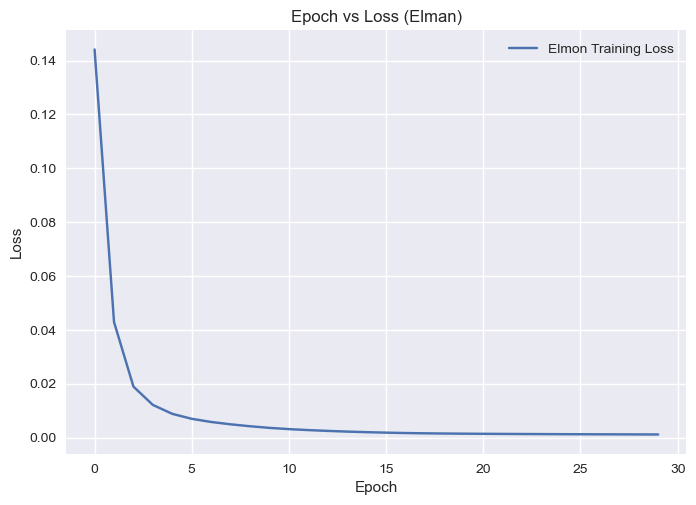

In [23]:
# Plotting Training Loss against Epochs

plt.plot(elmon_loss_dict.keys(), elmon_loss_dict.values(), label='Elmon Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (Elman)')
plt.legend()
plt.show()

In [24]:
# Evaluating the performance of the Elmon Model on test data
torch.manual_seed(42)

# Set the model in evaluation mode
Elmon_Model.eval()

# Lists to store predictions and true labels
predictions_elmon = []
true_labels_elmon = []

# Iterate over the testing data
with torch.no_grad():
    
    for _,test in enumerate(test_data):
        
        X_true = test[0]
        Y_true = test[1]
        
        ht_prev = torch.zeros(1, hidden_layer_size, requires_grad=False, dtype=torch.float64)
        y_pred = 0

        # Forward pass through the Elmon_Model
        for time_step in range(X_true.shape[0]):
            y_pred, ht_prev = Elmon_Model(X_true[time_step, :], ht_prev)

        # Append predictions and true labels
        predictions_elmon.append(y_pred.item())
        true_labels_elmon.append(Y_true.item())

# Calculate SmmothL1Loss, Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae_elmon = mean_absolute_error(true_labels_elmon, predictions_elmon)
mse_elmon = mean_squared_error(true_labels_elmon, predictions_elmon)

predictions_elmon_tensor = torch.tensor(predictions_elmon)
# true_labels_tensor = torch.tensor(true_labels)
true_labels_elmon_tensor = torch.tensor(true_labels_elmon)


# Calculate SmoothL1Loss
l1_elmon = F.smooth_l1_loss(predictions_elmon_tensor, true_labels_elmon_tensor, reduction='mean', beta=1.0)


print(f'Elmon SmmothL1Loss: {l1_elmon}')
print(f'Elmon Mean Absolute Error (MAE): {mae_elmon}')
print(f'Elmon Mean Squared Error (MSE): {mse_elmon}')

Elmon SmmothL1Loss: 0.0008979536360129714
Elmon Mean Absolute Error (MAE): 0.03582102839400172
Elmon Mean Squared Error (MSE): 0.001795907241110614


LSTM (Long Short Term Memory)

In [25]:
class LSTM_Gates(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super().__init__()
        

        # Input gate parameters
        self.W_ii = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hi = nn.Linear(hidden_size, hidden_size)
        self.b_ii = nn.Parameter(torch.zeros(hidden_size))
        self.b_hi = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate parameters
        self.W_if = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hf = nn.Linear(hidden_size, hidden_size)
        self.b_if = nn.Parameter(torch.zeros(hidden_size))
        self.b_hf = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate parameters
        self.W_ig = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hg = nn.Linear(hidden_size, hidden_size)
        self.b_ig = nn.Parameter(torch.zeros(hidden_size))
        self.b_hg = nn.Parameter(torch.zeros(hidden_size))

        # Output gate parameters
        self.W_io = nn.Linear(input_size, hidden_size, bias=False)
        self.W_ho = nn.Linear(hidden_size, hidden_size)
        self.b_io = nn.Parameter(torch.zeros(hidden_size))
        self.b_ho = nn.Parameter(torch.zeros(hidden_size))
        
        self.double()

    def forward(self, x, hidden):
        
        
        h_t, c_t = hidden

        # Input gate
        i_t = torch.sigmoid(self.W_ii(x) + self.b_ii + self.W_hi(h_t) + self.b_hi)

        # Forget gate
        f_t = torch.sigmoid(self.W_if(x) + self.b_if + self.W_hf(h_t) + self.b_hf)

        # Cell gate
        g_t = torch.tanh(self.W_ig(x) + self.b_ig + self.W_hg(h_t) + self.b_hg)

        # Output gate
        o_t = torch.sigmoid(self.W_io(x) + self.b_io + self.W_ho(h_t) + self.b_ho)

        # Cell state update
        c_t = f_t * c_t + i_t * g_t

        # Hidden state update
        h_t = o_t * torch.tanh(c_t)
        

        return h_t, c_t
    
    
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super().__init__()
        
        self.initialise_lstm(input_size, hidden_size, output_size)
        
    def initialise_lstm(self,input_size, hidden_size, output_size):
        
        self.lstm = LSTM_Gates(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.double()

    def forward(self, input_data, hidden):
        h_t, c_t = hidden

        # Iterating over each time step
        for x in input_data.split(1, dim=1):
            x = x.squeeze(1)
            h_t, c_t = self.lstm(x, (h_t, c_t))
        
        output_result = self.fc(h_t)
        
        return output_result
    
    
LSTM_Model = LSTM(input_layer_size, hidden_layer_size, output_layer_size)
print(LSTM_Model)

LSTM(
  (lstm): LSTM_Gates(
    (W_ii): Linear(in_features=2, out_features=8, bias=False)
    (W_hi): Linear(in_features=8, out_features=8, bias=True)
    (W_if): Linear(in_features=2, out_features=8, bias=False)
    (W_hf): Linear(in_features=8, out_features=8, bias=True)
    (W_ig): Linear(in_features=2, out_features=8, bias=False)
    (W_hg): Linear(in_features=8, out_features=8, bias=True)
    (W_io): Linear(in_features=2, out_features=8, bias=False)
    (W_ho): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


In [26]:
# Training the created LSTM Model
LSTM_Model.train()

# Define optimizer and loss function
opt_lstm = torch.optim.Adam(LSTM_Model.parameters(), lr=learning_rate)

lstm_loss = nn.MSELoss()

# Create a defaultdict to store losses
lstm_loss_dict = defaultdict(int)

for i in range(iterations):

    iter_loss = 0

    for _, train in enumerate(train_data):

        X_true = train[0]
        Y_true = train[1]

        X_true = torch.tensor(X_true, dtype=torch.float64).unsqueeze(0)
        Y_true = torch.tensor(Y_true, dtype=torch.float64)

        LSTM_Model.zero_grad()

        # Initialize hidden state and cell state
        hidden_state = torch.zeros(1, hidden_layer_size, dtype=torch.float64)
        cell_state = torch.zeros(1, hidden_layer_size, dtype=torch.float64)

        # Forward pass
        output = LSTM_Model(X_true, (hidden_state, cell_state))
        

        # Calculate loss
        current_loss = lstm_loss(output, Y_true)
        

        # Backward pass
        current_loss.backward()

        # Update parameters
        opt_lstm.step()

        # Save current loss
        iter_loss += current_loss
        
    # Calculate average loss for the epoch
    lstm_loss_dict[i] = iter_loss / len(train_data)


    if i!=0:
        loss_change_percentage = ((lstm_loss_dict[i-1]-lstm_loss_dict[i])/lstm_loss_dict[i-1]) * 100
        print(f'Epoch {i + 1}: \t Loss = {lstm_loss_dict[i]}\t Loss Change Percentage = {loss_change_percentage}%')
        print("-"*115)

    else:
        print(f'Epoch {i + 1}: \t Loss = {lstm_loss_dict[i]}\t')
        print("-"*115)

Epoch 1: 	 Loss = 0.11712468333646672	
-------------------------------------------------------------------------------------------------------------------
Epoch 2: 	 Loss = 0.005499558134604935	 Loss Change Percentage = 95.30452678466908%
-------------------------------------------------------------------------------------------------------------------
Epoch 3: 	 Loss = 0.0026595736220409115	 Loss Change Percentage = 51.64023077952309%
-------------------------------------------------------------------------------------------------------------------
Epoch 4: 	 Loss = 0.001695850786120686	 Loss Change Percentage = 36.23599015772615%
-------------------------------------------------------------------------------------------------------------------
Epoch 5: 	 Loss = 0.0011414278715433138	 Loss Change Percentage = 32.69290665870626%
-------------------------------------------------------------------------------------------------------------------
Epoch 6: 	 Loss = 0.0007959464946923127	 Lo

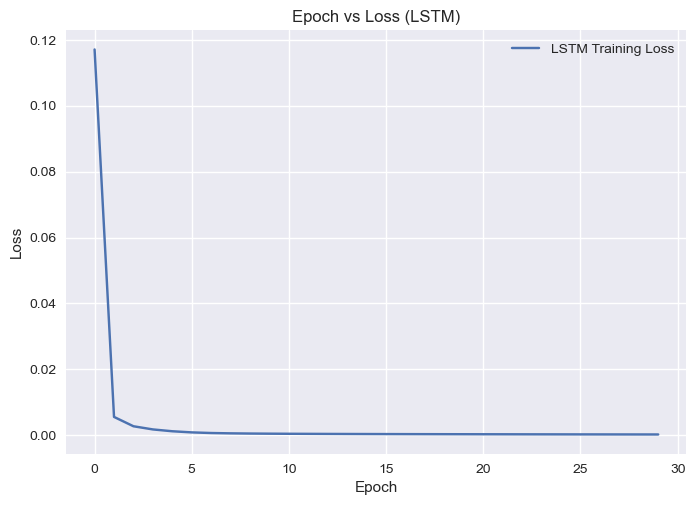

In [27]:
# Plotting Training Loss against Epochs

plt.plot(lstm_loss_dict.keys(), [val.item() for val in lstm_loss_dict.values()], label='LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (LSTM)')
plt.legend()
plt.show()

In [28]:
torch.manual_seed(42)
# Set the model in evaluation mode
LSTM_Model.eval()

# Lists to store predictions and true labels
predictions_lstm = []
true_labels_lstm = []

correct = 0

# Iterate over the testing data
with torch.no_grad():
    for _, test in enumerate(test_data):
        
        X_lstm_true = test[0]
        Y_lstm_true = test[1]
        
        X_lstm_true = torch.tensor(X_lstm_true, dtype=torch.float64).unsqueeze(0)  # Add batch dimension
        Y_lstm_true = torch.tensor(Y_lstm_true, dtype=torch.float64)

        # Initialize hidden state for LSTM
        hidden_lstm = (torch.zeros(1, hidden_layer_size, dtype=torch.float64), torch.zeros(1, hidden_layer_size, dtype=torch.float64))

        # Forward pass through the LSTM Model
        output_lstm = LSTM_Model(X_lstm_true, hidden_lstm)

        # Append predictions and true labels
        predictions_lstm.append(output_lstm.item())
        true_labels_lstm.append(Y_lstm_true.item())


# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE) for LSTM
mae_lstm = mean_absolute_error(true_labels_lstm, predictions_lstm)
mse_lstm = mean_squared_error(true_labels_lstm, predictions_lstm)

predictions_lstm_tensor = torch.tensor(predictions_lstm)
true_labels_lstm_tensor = torch.tensor(true_labels_lstm)
l1_lstm = F.smooth_l1_loss(predictions_lstm_tensor, true_labels_lstm_tensor, reduction='mean', beta=1.0)

print(f'LSTM Mean Absolute Error (MAE): {mae_lstm}')
print(f'LSTM Mean Squared Error (MSE): {mse_lstm}')
print(f'LSTM SmoothL1Loss: {l1_lstm}')

LSTM Mean Absolute Error (MAE): 0.0126035988632513
LSTM Mean Squared Error (MSE): 0.00021707972246370977
LSTM SmoothL1Loss: 0.00010853986896108836


GRU (Gated Recurrent Unit)

In [29]:
class GRU_Gates(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        
        super().__init__()

        self.double()

        # Reset gate parameters
        self.W_ir = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hr = nn.Linear(hidden_size, hidden_size)

        # Update gate parameters
        self.W_iz = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hz = nn.Linear(hidden_size, hidden_size)

        # Candidate hidden state parameters
        self.W_in = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hn = nn.Linear(hidden_size, hidden_size)


    def forward(self, x, hidden):
        self.double()

        h_t = hidden

        # Reset gate
        r_t = torch.sigmoid(self.W_ir(x) + self.W_hr(h_t))

        # Update gate
        z_t = torch.sigmoid(self.W_iz(x) + self.W_hz(h_t))

        # Candidate hidden state
        n_t = torch.tanh(self.W_in(x) + r_t * self.W_hn(h_t))

        # Hidden state update
        h_t = (1 - z_t) * h_t + z_t * n_t

        return h_t
    
class GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super().__init__()
        
        self.intialise_gru(input_size, hidden_size, output_size)
        
    def intialise_gru(self,input_size, hidden_size, output_size):
        
        self.gru = GRU_Gates(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.double()

    def forward(self, input_data, hidden):
        h_t = hidden

        # Iterating over each time step
        for x in input_data.split(1, dim=1):
            x = x.squeeze(1)
            h_t = self.gru(x, h_t)

        return (self.fc(h_t))


# Create the GRU model
GRU_Model = GRU(input_layer_size, hidden_layer_size, output_layer_size)
print(GRU_Model)

GRU(
  (gru): GRU_Gates(
    (W_ir): Linear(in_features=2, out_features=8, bias=False)
    (W_hr): Linear(in_features=8, out_features=8, bias=True)
    (W_iz): Linear(in_features=2, out_features=8, bias=False)
    (W_hz): Linear(in_features=8, out_features=8, bias=True)
    (W_in): Linear(in_features=2, out_features=8, bias=False)
    (W_hn): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


In [30]:
# Training the created GRU Model
GRU_Model.train()

# Define optimizer and loss function
opt_gru = torch.optim.Adam(GRU_Model.parameters(), lr=learning_rate)

gru_loss = nn.MSELoss()

# Training loop
gru_loss_dict = defaultdict(int)

for i in range(iterations):
    iter_loss = 0

    for _, train in enumerate(train_data):

        X_true = train[0]
        Y_true = train[1]

        X_true = torch.tensor(X_true, dtype=torch.float64).unsqueeze(0)  # Add batch dimension
        Y_true = torch.tensor(Y_true, dtype=torch.float64)

        GRU_Model.zero_grad()

        hidden_state = torch.zeros(1, hidden_layer_size, dtype=torch.float64)

        # Forward pass
        output = GRU_Model(X_true, hidden_state)

        # Calculate loss
        current_loss = gru_loss(output, Y_true)

        # Backward pass
        current_loss.backward()

        # Update parameters
        opt_gru.step()

        # Save current loss
        iter_loss += current_loss

    # Calculate mean loss for the epoch
    gru_loss_dict[i] = iter_loss / len(train_data)

    if i!=0:
        loss_change_percentage = ((gru_loss_dict[i-1]-gru_loss_dict[i])/gru_loss_dict[i-1]) * 100
        print(f'Epoch {i + 1}: \t Loss = {gru_loss_dict[i]}\t Loss Change Percentage = {loss_change_percentage}%')
        print("-"*115)

    else:
        print(f'Epoch {i + 1}: \t Loss = {gru_loss_dict[i]}\t')
        print("-"*115)

Epoch 1: 	 Loss = 0.1197459402843428	
-------------------------------------------------------------------------------------------------------------------
Epoch 2: 	 Loss = 0.009668290329524837	 Loss Change Percentage = 91.92599740202716%
-------------------------------------------------------------------------------------------------------------------
Epoch 3: 	 Loss = 0.0024895419665249947	 Loss Change Percentage = 74.25044261525245%
-------------------------------------------------------------------------------------------------------------------
Epoch 4: 	 Loss = 0.0013364330553733807	 Loss Change Percentage = 46.318115004952936%
-------------------------------------------------------------------------------------------------------------------
Epoch 5: 	 Loss = 0.0009210390976384386	 Loss Change Percentage = 31.082286992586162%
-------------------------------------------------------------------------------------------------------------------
Epoch 6: 	 Loss = 0.000686039367656293	 L

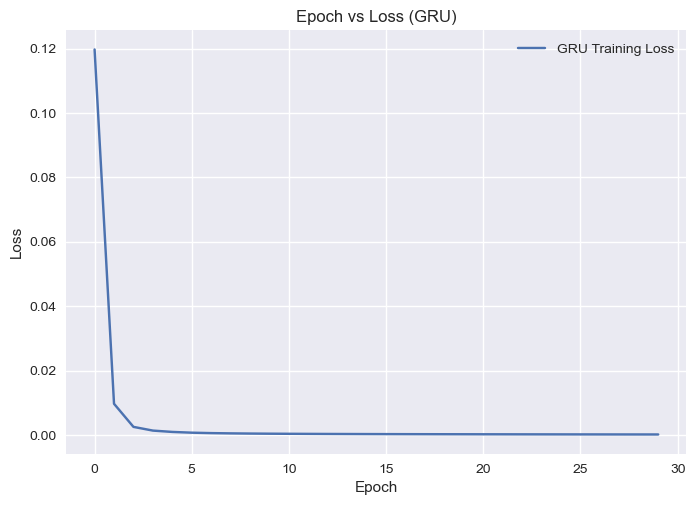

In [31]:
# Plotting Training Loss against Epochs
#plt.plot(gru_loss_dict.keys(), gru_loss_dict.values(), label='GRU Training Loss')
plt.plot(gru_loss_dict.keys(), [val.item() for val in gru_loss_dict.values()], label='GRU Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (GRU)')
plt.legend()
plt.show()

In [32]:

# Set the model in evaluation mode
torch.manual_seed(42)
GRU_Model.eval()

# Lists to store predictions and true labels
predictions_gru = []
true_labels_gru = []


# Iterate over the testing data
with torch.no_grad():
    for _,test in enumerate(test_data):
        
        X_gru_true = test[0]
        Y_gru_true = test[1]
        
        X_gru_true = torch.tensor(X_gru_true, dtype=torch.float64).unsqueeze(0)  # Add batch dimension
        Y_gru_true = torch.tensor(Y_gru_true, dtype=torch.float64)

        # Initialize hidden state for GRU
        hidden_gru = torch.zeros(1, hidden_layer_size, dtype=torch.float64)

        # Forward pass through the GRU Model
        output_gru = GRU_Model(X_gru_true, hidden_gru)

        # Append predictions and true labels
        predictions_gru.append(output_gru.item())
        true_labels_gru.append(Y_gru_true.item())


# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE) for GRU
mae_gru = mean_absolute_error(true_labels_gru, predictions_gru)
mse_gru = mean_squared_error(true_labels_gru, predictions_gru)

predictions_gru_tensor = torch.tensor(predictions_gru)
true_labels_gru_tensor = torch.tensor(true_labels_gru)
l1_gru = F.smooth_l1_loss(predictions_lstm_tensor, true_labels_lstm_tensor, reduction='mean', beta=1.0)

print(f'GRU Mean Absolute Error (MAE): {mae_gru}')
print(f'GRU Mean Squared Error (MSE): {mse_gru}')
print(f'GRU SmoothL1Loss: {l1_gru}')

GRU Mean Absolute Error (MAE): 0.010789015356816922
GRU Mean Squared Error (MSE): 0.00015764987123858027
GRU SmoothL1Loss: 0.00010853986896108836


Comapring Learning Curves of all three RNNs with baseline

In [33]:
class BaseLine(nn.Module):
    def forward(self, x):
        return torch.ones_like(x)
    
Baseline_Model = BaseLine()
print(Baseline_Model)

BaseLine()


In [34]:
torch.manual_seed(42)

baseline_loss_dict = defaultdict(float)

for i in range(iterations):
    iter_loss = 0

    for _, train in enumerate(train_data):
        X_true = train[0]
        Y_true = train[1]

        # Instantiate the MSELoss object
        mse_loss = nn.MSELoss()

        # Calculate the loss for the current iteration
        baseline_output = Baseline_Model(X_true)
        baseline_loss = mse_loss(baseline_output, Y_true)

        # Accumulate the loss for the current iteration
        iter_loss += baseline_loss.item()

    # Calculate the average loss for the current iteration
    baseline_loss_dict[i] = iter_loss / len(train_data)

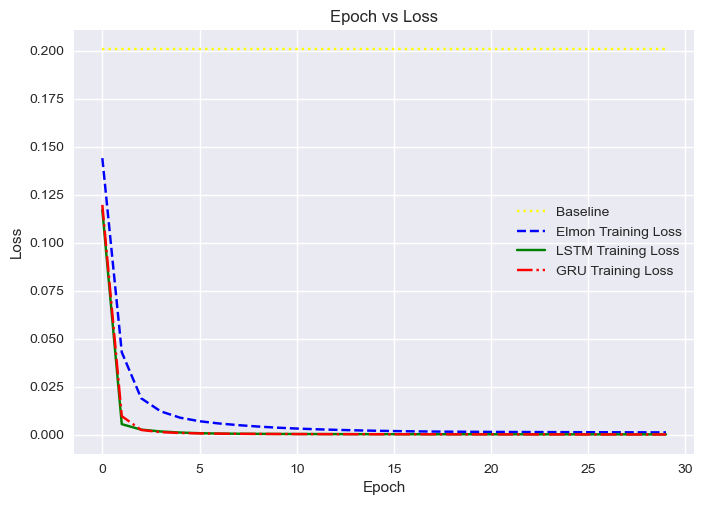

In [36]:
plt.plot(baseline_loss_dict.keys(), baseline_loss_dict.values(), label = 'Baseline', linestyle=':', color='yellow')
plt.plot(elmon_loss_dict.keys(), elmon_loss_dict.values(), label='Elmon Training Loss', linestyle='--', color='blue')
plt.plot(lstm_loss_dict.keys(), [val.item() for val in lstm_loss_dict.values()], label='LSTM Training Loss', linestyle='-', color='green')
plt.plot(gru_loss_dict.keys(), [val.item() for val in gru_loss_dict.values()], label='GRU Training Loss', linestyle='-.', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()